## Notebook to run retrieval for GMI IWP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiSatData import gmiSatData
from iwc2tb.GMI.gmiData import gmiData
from iwc2tb.GMI.GMI_SatData import GMI_Sat
import os
import numpy.ma as ma
import glob
#from iwc2tb.GMI.write_training_data import *
from tqdm.notebook import tqdm
import xarray
import torch

from quantnn.qrnn import QRNN
import time


## Set inputs

In [2]:
batchSize          = 4
inputs             = np.array(["ta", "t2m",  "wvp", "z0", "lat", "stype"])
outputs            = "iwp"

latlims            = [0, 65]
pr                 = None
training_data      = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train_jan_lpa.nc"), 
                             inputs, 
                             outputs,
                             pratio = pr,
                             batch_size = batchSize,
                             latlims = latlims,
                             )


norm               = training_data.norm


year               = '2020'
month              = '01'


inpath             = os.path.join(os.path.expanduser('~/Dendrite/SatData/GMI/L1B/'), year, month)
gmifiles           = glob.glob(os.path.join(inpath, "*/*.HDF5"))

outpath            = "~/Dendrite/UserAreas/Kaur/IWP/lpa"

qrnnfile           = "qrnn_gmi_nn_lpa.nc"
qrnn               =  QRNN.load(os.path.join(os.path.expanduser('~/Dendrite/Projects/IWP/GMI/training_data/try_training/')
                                                  , qrnnfile))
quantiles          = qrnn.quantiles
imedian            = np.argwhere((quantiles >= 0.49) & (quantiles < 0.51))[0][0]


In [3]:
training_data.pr

array([[1.21079808],
       [1.30948333],
       [1.27813339],
       ...,
       [1.14349101],
       [1.22819043],
       [1.07394615]])

In [4]:
def get_pos_mean(validation_data, qrnn):
    
    quantiles  = qrnn.quantiles
    nquantiles = len(quantiles)
    
    y          = validation_data.y
    y_mean     = np.zeros(validation_data.y.shape)
    y_pre      = np.zeros([validation_data.y.shape[0],validation_data.y.shape[1], len(quantiles)])



    nbatch = len(validation_data)
    ibatch = validation_data.batch_size
    nscan  = validation_data.y.shape[0]
    npix   = validation_data.y.shape[1]
    
    with torch.no_grad():
        for i in range(nbatch):
            
            istart                      = ibatch * i
            iend                        = ibatch * (i + 1) 

            xx, yy                      = validation_data[i]

            xx                          = xx.reshape(-1, validation_data.x.shape[-1])
            y_pred                      = qrnn.predict(xx)
            y_pre[istart:iend, :, :]    = y_pred.reshape(-1, npix, nquantiles).detach().numpy()
            y_mean[istart:iend]         = qrnn.posterior_mean(xx, y_pred).reshape(-1, npix).detach().numpy() 
                   
    return y, y_pre, y_mean

In [5]:
def get_coords(validation_data):
    lat   = validation_data.lat
    lon   = validation_data.lon%360
    t     = validation_data.lst
    stype = validation_data.stype
    tb    = validation_data.x[:, :, :4]
    return tb, lat, lon, stype, t

In [6]:
def predict_iwp(qrnn, filename):


    gmi_s    = GMI_Sat(filename)  

    validation_data    = gmiSatData(gmi_s, 
                             inputs, outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             normalize = norm,      
                             )

    y, y_pre, y_mean = get_pos_mean(validation_data, qrnn)
    
    
    
    tb, lat,  lon, stype, t    = get_coords(validation_data)
    
    return y, y_pre, y_mean, lat, lon, tb, stype, t
    

In [7]:
def plot_iwp(lat, lon, iwp0, iwp,tb, mask):
    
    fig, ax = plt.subplots(1, 2, figsize = [12, 6])
    ax = ax.ravel()
    diff = 100 * (np.exp(np.abs(np.log(iwp/iwp0))) - 1)
    
    bbox = [np.min(lon),np.min(lat),np.max(lon),np.max(lat)] # set bounds for plotting
    n_add = 0
    m = Basemap(llcrnrlon=bbox[0]-n_add,llcrnrlat=bbox[1]-n_add,
                urcrnrlon=bbox[2]+n_add,urcrnrlat=bbox[3]+n_add,resolution='l',
                projection='cyl')
    x, y = m(lon, lat)    
    for var, axes, t in zip([iwp0, iwp], ax, ["GMI", "QRNN"]):
        
        cs = axes.scatter(lon[mask],lat[mask], c = var[mask]* 1000,
                          norm=colors.LogNorm(), vmin = 1, vmax = 10000,)
                        # cmap = cm.Paired)
            
        #cs = m.scatter(lon, lat, var[mask]* 1000, ax = axes)    
        axes.set_title(t)
        ax[0].set_ylabel("Latitude [deg]")
        #axes.set_xlabel("Longitude [deg]")
    cbar = fig.colorbar(cs, ax=[ax[0], ax[1]])
    cbar.ax.set_ylabel("IWP [g/m2]")
      

def get_mask(lat, lon, latlims, lonlims):
    
    im  = (lat >= latlims[0]) & (lat <= latlims[1])
    im1 = (lon >=  lonlims[0]) & (lon < lonlims[1])
    mask  = np.logical_and(im, im1)
    
    return mask    

## Loop over all files

In [8]:
for gmifile in tqdm(gmifiles[201:]):
    print (gmifile)
    bname = os.path.basename(gmifile)
    outfile = os.path.join(outpath, bname[:-5] + ".nc")
    #try:
    y, y_pre, y_pos_mean, lat, lon, tb, stype, t = predict_iwp(qrnn, gmifile)
    y_pre[y_pre < 0] = 0
    y_pos_mean[y_pos_mean < 0] = 0


    stype = np.argmax(stype, axis = 2)

    print (np.nanmax(y_pos_mean))

    d = xarray.Dataset({
    "iwp": (["scans", "pixels"], y_pre[:, :, imedian]),
    "iwp_mean": (["scans", "pixels"], y_pos_mean),
    "stype": (["scans", "pixels"], stype),
    "local_time": (["scans", "pixels"], t),

    },
    coords={
    "lon": (["scans", "pixels"], lon),
    "lat": (["scans", "pixels"], lat),
    #"quantiles": (["quantiles"], qrnn.quantiles)
    })

    d.to_netcdf(outfile, mode = "w")


        
        
        
    #except:
    #    print ("file not available")
    #    continue

  0%|          | 0/281 [00:00<?, ?it/s]

/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/13/1B.GPM.GMI.TB2016.20200113-S132607-E145839.033383.V05A.HDF5
24.482202529907227
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S075648-E092920.033395.V05A.HDF5
21.16167449951172
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S171208-E184441.033401.V05A.HDF5
17.510902404785156
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S214949-E232221.033404.V05A.HDF5
28.91335678100586
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S092921-E110154.033396.V05A.HDF5
32.718727111816406
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S031908-E045140.033392.V05A.HDF5
25.109189987182617
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114-S110155-E123427.033397.V05A.HDF5
24.95809555053711
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/14/1B.GPM.GMI.TB2016.20200114

8.657464027404785
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/17/1B.GPM.GMI.TB2016.20200117-S034918-E052150.033439.V05A.HDF5
32.068145751953125
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S090752-E104024.033458.V05A.HDF5
23.79227066040039
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S073518-E090751.033457.V05A.HDF5
27.524545669555664
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S060245-E073517.033456.V05A.HDF5
13.96328353881836
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S182312-E195544.033464.V05A.HDF5
16.318204879760742
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S151805-E165037.033462.V05A.HDF5
25.516666412353516
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.GMI.TB2016.20200118-S104025-E121258.033459.V05A.HDF5
20.570125579833984
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/18/1B.GPM.

33.33935546875
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S101851-E115123.033521.V05A.HDF5
22.795560836791992
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S040838-E054110.033517.V05A.HDF5
21.738847732543945
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S180138-E193410.033526.V05A.HDF5
24.958921432495117
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S132358-E145630.033523.V05A.HDF5
28.11683464050293
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S054111-E071343.033518.V05A.HDF5
25.068628311157227
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S193411-E210643.033527.V05A.HDF5
24.532548904418945
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI.TB2016.20200122-S223917-E001150.033529.V05A.HDF5
23.60247802734375
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/22/1B.GPM.GMI

26.860034942626953
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S082439-E095712.033582.V05A.HDF5
23.24599838256836
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S173959-E191231.033588.V05A.HDF5
26.832332611083984
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S112946-E130218.033584.V05A.HDF5
26.018007278442383
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S235012-E012244.033592.V05A.HDF5
27.844562530517578
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S051933-E065205.033580.V05A.HDF5
24.31919288635254
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S130219-E143451.033585.V05A.HDF5
22.316553115844727
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM.GMI.TB2016.20200126-S204506-E221738.033590.V05A.HDF5
27.719524383544922
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/26/1B.GPM

26.238420486450195
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S154544-E171816.033649.V05A.HDF5
26.070470809936523
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S080258-E093530.033644.V05A.HDF5
27.325191497802734
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S032518-E045751.033641.V05A.HDF5
22.300216674804688
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S110804-E124036.033646.V05A.HDF5
24.161348342895508
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S185050-E202322.033651.V05A.HDF5
26.673477172851562
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S002012-E015244.033639.V05A.HDF5
27.376514434814453
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.GPM.GMI.TB2016.20200130-S232829-E010101.033654.V05A.HDF5
27.727170944213867
/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/30/1B.G

In [9]:
gmi_s    = GMI_Sat(gmifiles[:1])  

validation_data    = gmiSatData(gmi_s, 
                         inputs, outputs,
                         batch_size = batchSize,
                         latlims = latlims,
                         normalize = norm,      )

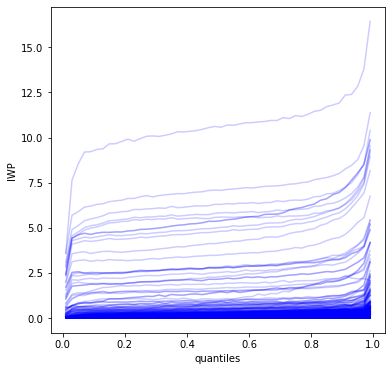

In [13]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
rndinds = np.random.randint(1, 2700, 1000)
for i in rndinds:
    ax.plot(quantiles, y_pre[i, 10, :], 'b', alpha = 0.2)
ax.set_xlabel("quantiles")
ax.set_ylabel("IWP")
fig.savefig("quantiles.png")

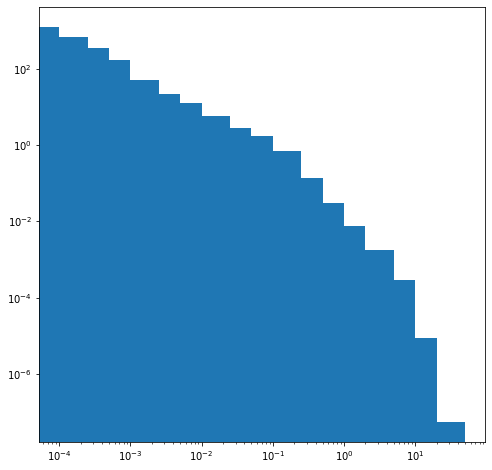

In [11]:
bins = np.array([0.0,.0001,.00025,.0005,0.001,.0025,.005,.01,.025,.05,.1,.25,.5,1,2, 5, 10, 20, 50])
  
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
ax.hist(y_pos_mean.ravel(), bins = bins , density = True)
ax.set_yscale('log')
ax.set_xscale("log")

In [12]:
import pickle
IWP  = np.concatenate(IWP, axis = 0)
LAT  = np.concatenate(LAT, axis = 0)
LON  = np.concatenate(LON, axis = 0)
LSM  = np.concatenate(LSM, axis = 0)
IWP0 = np.concatenate(IWP0, axis = 0)
IWP_mean = np.concatenate(IWP_mean, axis = 0)
with open("jan2020_IWP.pickle", "wb") as f:
    pickle.dump(IWP, f)
    pickle.dump(IWP0, f)
    pickle.dump(IWP_mean, f)
    pickle.dump(LON, f)
    pickle.dump(LAT, f)
    pickle.dump(LSM, f)
    
    
    f.close()

NameError: name 'IWP' is not defined